In [1]:
!pip install PersianStemmer
!pip install transformers
!pip install https://github.com/htaghizadeh/PersianStemmer-Python/archive/master.zip --upgrade
!pip install hazm
!pip install demoji

     |████████████████████████████████| 810 kB 23.0 MB/s 
  Created wheel for PersianStemmer: filename=PersianStemmer-1.0.0-py3-none-any.whl size=810281 sha256=255dfc103e2bfebc4750a3050c7cefa4f25a846652f3e4bca0060de3f6c14ee2
  Stored in directory: /root/.cache/pip/wheels/d2/f7/96/55f0070725e6ce1191aa9a931e962fc0f551b68ed919fb7f8e
  Created wheel for patricia-trie: filename=patricia_trie-10-py3-none-any.whl size=7768 sha256=1b0c2b46ed3902d42078892a3a7c49a268634d23eb04af70887163ec573ae8dd
  Stored in directory: /root/.cache/pip/wheels/32/89/b4/46456cda461ffee3f6ef09a68bccb5d175b65ff2b922b5b5b8
Successfully built PersianStemmer patricia-trie
     |████████████████████████████████| 4.0 MB 16.4 MB/s 
     |████████████████████████████████| 596 kB 51.9 MB/s 
     |████████████████████████████████| 895 kB 44.3 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 6.6 MB 43.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: P

In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0, '/content/drive/My Drive/modules') #Adds preprocessing module to current session.

Mounted at /content/drive


In [3]:
import pandas as pd
import preprocess
import numpy as np
import tensorflow as tf
import demoji
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)
demoji.download_codes()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.


In [4]:
def create_vector_from_data(train_data_df, test_data_df):
    train_sentence_list = [row.sentence for index, row in train_data_df.iterrows()]
    train_labels_list = [row.label for index, row in train_data_df.iterrows()]
    tokenizer = Tokenizer(oov_token='<UNK>')
    tokenizer.fit_on_texts(train_sentence_list)
    train_sequences = tokenizer.texts_to_sequences(train_sentence_list)
    maxlen = max([len(x) for x in train_sequences])
    train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)

    test_sentence_list = [row.sentence for index, row in test_data_df.iterrows()]
    test_labels_list = [row.label for index, row in test_data_df.iterrows()]
    test_sequences = tokenizer.texts_to_sequences(test_sentence_list)
    test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)
    return train_padded, train_labels_list, test_padded, test_labels_list, len(tokenizer.word_index)+1, maxlen

In [5]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [6]:
dataset = pd.read_csv('/content/drive/MyDrive/data/initial_dataset.csv')
dataset = preprocess.auto_preprocess(dataframe=dataset, stop_words_type='custom', stemming = True)
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
train_vectors, train_labels_list, test_vectors, test_labels_list, vocab_size, maxlen = create_vector_from_data(train_data_df=train, test_data_df=test)

custom stop words selected


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

there are 5 outlier in data
current dataframe length before remove 5 outlier sentence is: 2000
current dataframe length after remove 5 outlier sentence is: 1995
auto preprocess completed done on dataframe!
Enjoy!


In [7]:
dataset = tf.data.Dataset.from_tensor_slices((train_vectors, train_labels_list))
train_data = dataset.shuffle(100).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((test_vectors, test_labels_list))
test_data = test_dataset.batch(64)

In [8]:
checkpoint_filepath = './'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=maxlen, mask_zero=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
model.summary()
history = model.fit(train_data, epochs=6, validation_data=test_data, class_weight={0: 1, 1: 6},
                    callbacks=[model_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 108, 50)           168350    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 197,855
Trainable params: 197,855
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
100/100 [==============================] - 11s 22ms/step - loss: 1.1327 - accuracy: 0.6078 - val_loss: 0.5943 - val_accuracy: 0.7569
Epoch 2/6
100/100 [==============================] - 1s 9ms/step - loss: 0.5068 - accuracy: 0.9148 - val_loss: 0.3430 - val_accuracy: 0.8822
Epoch 3/6
100/100 [===========

In [9]:
# keras.utils.plot_model(model)

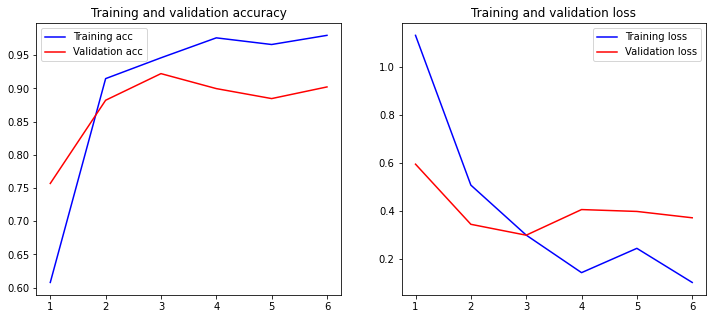

In [10]:
plot_history(history)

In [11]:
model.load_weights(checkpoint_filepath)

In [12]:
# results = model.predict_classes(test_data)
results = (model.predict(test_data) > 0.5).astype("int32")

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [14]:
f1 = (f1_score(test_labels_list,results ))*100
f1 = round(f1,2)
print('f1 score is: ',f1)

accuracy = (accuracy_score(test_labels_list,results ))*100
accuracy = round(accuracy,2)
print('accuracy score is: ',accuracy)

precision = (precision_score(test_labels_list,results ))*100
precision = round(precision,2)
print('precision score is: ',precision)

recall = (recall_score(test_labels_list,results ))*100
recall = round(recall,2)
print('recall score is: ',recall)


f1 score is:  77.37
accuracy score is:  92.23
precision score is:  79.1
recall score is:  75.71
